# <center>  Notebook S11. Coagulation Theory and PartMC Simulations </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 


This notebook presents an overview over coagulation theory. It is shown how to predict the coagulated distribution using Size Distribution Arithmetic (Notebook S3). The approach is compared to model predictions with the Particle-resolved Monte Carlo code for atmospheric aerosol simulation [(PartMC)](http://lagrange.mechse.illinois.edu/partmc/). The notebook is a supplement to the manuscript <br>

Petters, M. D. (2018) <i> A language to simplify computation of differential mobility analyzer response functions</i>, Aerosol Science & Technology. <br>

__ Note that exectuting this Notebook requires that PartMC is installed. The Julia/PartMC interface has only been tested on a linux install. __

### Problem description
Two aerosol populations with identities "1" and "2" are introduced into in a chamber. Each population has unique and defined chemical composition, charge state (0, ±1, or ±2) and size distribution (𝕟₁ and 𝕟₂). Chemical composition and charge state are identical for particles within a population. There are no wall losses in the chamber. What is the size distribution of dimers comprising one "1" and one "2" particle (denoted 𝕟₁₂) after elapsed time $t$ due to coagulation?

<img src="Figures/nbs11_f01.png" width="800" align = "middle">
<b> Figure 1. </b> Schematic of problem setup. The two populations, each generated by a differential mobility analyzer, enter a chamber where they are allowed to coagulate. After time $t$ (1,2) coagulated particles emerge. This sheet demonstrates how to model that distribution. <br>


### Coagulation Theory

For monodisperse particles the rate of coagulation is <br>

<center> $\frac{dN}{dt} = \beta_{i,j}N_iN_j$ </center>

where $N_i$ and $N_j$ are number concentrations and $\beta_{i,j}$ is the coagulation kernel. For submicron particles, Brownian motion dominates the collision rate between particles of size $i$ and $j$ and is given by (Jacobson, 2005, Eq. 15.33)

<center> $\beta_{i,j}^B = \frac{4\pi\left(r_i + r_j\right)\left(D_{i} + D_{j}\right)}{\frac{r_i + r_j}{r_i + r_j + \sqrt{\delta_i^2 + \delta_j^2}} + \frac{4\left(D_{i} + D_{j}\right)}{\sqrt{v_{p,i}^2 + v_{p,j}^2}\left(r_i + r_j\right) } }$ </center> 

where, $\beta_{i,j}^B$ denotes the Brownian coagulation kernel, $r_i$ and $r_j$ are the radii, $D_i$ and $D_j$ are the diffusion coefficient, and $v_i$ and $v_j$ are thermal velocities of particles $i$ and $j$ in air. The parameters $\delta_i$ and $\delta_j$ are the mean distances from the center of a sphere reached by particles leaving the sphere’s surface and traveling a distance of particle mean free path. Using the following relationships, the coagulation rate can be readily computed.
<center> $\delta_i = \frac{\left(2r_i + \lambda_{p,i} \right)^3 - \left(4r_i^2 + \lambda_{p,i}^2\right)^{3/2}}{6r_i\lambda_{p,i}} - 2r_i$ <br>
$\lambda_{p,i} = \frac{8D_i}{\pi v_i}$<br>
$v_i = \sqrt{\frac{8k_bT}{\pi M_i}}$<br>
$M_i = \frac{4}{3}\pi r_i^3 \rho_i$<br></center>
$D_i$ is defined in Notebook S1, and $\rho_i$ is the density and particle sphericity is assumed. The Brownian coagulation rate depends thus on the diameters $D_i$, $D_j$, densities $\rho_i$, $\rho_j$ as well as pressure and temperature for the free molecular regime corrections. <br>

Coagulation rates are enhanced or suppressed if particles carry the charges of the same or opposite polarity, respectively. The effect is described by Zebel (1958)

<center> $\beta_{i,j}^{z(k_i,k_j)} = \beta_{i,j}^B \frac{\frac{a}{r_i + r_j}}{exp\left(\frac{a}{r_i + r_j}\right)-1 + G_0 \frac{a}{rij} \exp{\frac{a}{r_i + r_j}}}$ </center>
<center> $a = k_i k_j\frac{e^2}{k_bT}$ </center>
<center> $G_0 = 4\frac{D_i + D_j}{r_i + r_j} \sqrt{\frac{M_i M_j}{(M_i + M_j) 3k_b T}}$ </center>
where, $k_i$, $k_j$ are the charges and $\beta_b$ is Boltzmann's constant, and $e$ is the elementary charge ($e = \sqrt{1.43996\; MeV\; fm}$). The Zebel-corrected Brownian coagulation rate ($\beta_{i,j}^{z(k_i,k_j)}$) depends on the diameters $D_i$, $D_j$, densities $\rho_i$, $\rho_j$, charges $k_i$, $k_j$, as well as pressure and temperature for the free molecular regime corrections. Note that for either $k_i = 0$ or $k_j = 0$ the regular Brownian coagulation rate is retained, i.e. $\beta_{i,j}^{z(k_i,k_j)} = \beta_{i,j}^B$  <br>

The above functions are implemented in file coagulationrates.jl. The rate is obtained through the function call

```julia
    β12 = β12(Dp_i, Dp_j, k_i, k_j;ρi = 1000.0, ρj = 1000.0, p = 1e5, T = 293.0)
```
The truncated call 
```julia
    β12 = β12(Dp_i, Dp_j, k_i, k_j)
```
assumes that ρi = 1000 kg m⁻³, ρj = 1000 kg m⁻³, p = 1e5 Pa, T = 293 K. Coagulation rates between particles of the same diameter (i.e. Dp_i = Dp_j) and enhancement factors based on charge state as a function of diameter are shown in Figure 2 below. 

In [1]:
using Plots, Plots.PlotMeasures, DifferentialMobilityAnalyzers, Printf, Random, LinearAlgebra
plotlyjs();

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

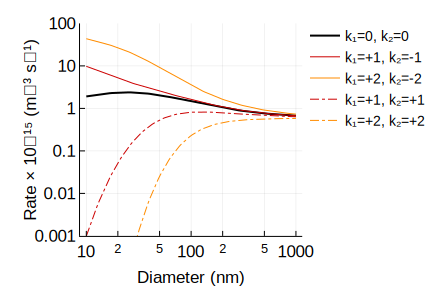

In [2]:
figure("Nimbus Sans L", 2, 3, 2, 8)
Dp = exp10.(range(log10(10e-9), stop=log10(1000e-9), length=100))
βᵢⱼ = map(Dp->β12(Dp, Dp, 0, 0), Dp)  # no charge
βᵢⱼᶻ⁽¹⁻¹⁾ = map(Dp->β12(Dp, Dp, 1, -1), Dp)  # +1 -1 charge
βᵢⱼᶻ⁽²⁻²⁾ = map(Dp->β12(Dp, Dp, 2, -2), Dp)  # +2 -2 charge
βᵢⱼᶻ⁽¹⁺¹⁾ = map(Dp->β12(Dp, Dp, 1, 1), Dp)   # +1 +1 charge
βᵢⱼᶻ⁽²⁺²⁾ = map(Dp->β12(Dp, Dp, 2, 2), Dp)   # +2 +2 charge
plot(Dp*1e9, βᵢⱼ*1e15, xaxis = :log10, xlabel = "Diameter (nm)", yaxis = :log10, ylim = (1e-3, 100),
    ylabel = "Rate × 10⁻¹⁵ (m⁻³ s⁻¹)", label = "k₁=0, k₂=0", left_margin = 30px, color = :black, lw = 2)
plot!(Dp*1e9, βᵢⱼᶻ⁽¹⁻¹⁾*1e15, label = "k₁=+1, k₂=-1", color = RGBA(0.8,0,0,1))
plot!(Dp*1e9, βᵢⱼᶻ⁽²⁻²⁾*1e15, label = "k₁=+2, k₂=-2", color = :darkorange)
plot!(Dp*1e9, βᵢⱼᶻ⁽¹⁺¹⁾*1e15, label = "k₁=+1, k₂=+1", color = RGBA(0.8,0,0,1), ls = :dashdot)
plot!(Dp*1e9, βᵢⱼᶻ⁽²⁺²⁾*1e15, label = "k₁=+2, k₂=+2", color = :darkorange, ls = :dashdot, fmt = :svg)

<b> Figure 2.</b> Zebel-corrected Brownian coagulatation rates between particles of the same diameter. Coagulation between oppositely charged particle is enhanced while coagulation between particles of equal polarity is suppressed. The effect of particle charge is strongest in the free molecular regime. Suppression of coagulation due to repelling charges is stronger than enhancement due to attraction. This is because the enhancement is proportional to $k_i k_j\frac{e^2}{k_bT(r_i + r_j)}$ while the supressenion is proportional to $\exp\left(k_i k_j\frac{e^2}{k_bT(r_i + r_j)}\right)$ (Zebel, 1957).

### Application to Distributions

Recall the original problem definition: two aerosol populations with identities "1" and "2" are introduced into in a chamber. Each population has unique and defined chemical composition, charge state (0, ±1, or ±2) and size distribution (𝕟₁ and 𝕟₂). Chemical composition and charge state are identical for particles within a population. There are no wall losses in the chamber. What is the size distribution of dimers comprising one "1" and one "2" particle (denoted 𝕟₁₂) after elapsed time $t$ due to coagulation? And further recall

<center> $\frac{dN}{dt} = \beta_{i,j}N_iN_j$ </center>

The general solution to this problem requires a coagulation model. However, assuming that the rate of dimer formation is small enough that number concentrations $N_1$ and $N_2$ are constant, assuming that $\beta_{i,j}$ is constant over the spread the size distribution, one might intuit the following solution to the stated problem in terms of the size distribution arithmetic formalism developed in Notebook S3

```julia
𝕟₁₂ = f⋅((β₁₂ᶻ*t)*(𝕟₁*𝕟₂))
```
where $t$ is time elapsed, β₁₂ᶻ is the Zebel-corrected Brownian coagulatation rate $f = \frac{\sqrt[3]{D_m^3 + D_m^3}}{D_m} = \sqrt[3]{2}$, $D_m$ is the mode diameter of the distribution, $⋅$ is the operator that shifts the distribution along the diameter axis, $*$ is the operator that scales the concentration of a distribution, $.*$ is the square of two size distributions. The factor $f$ accounts for the increase in sphere equivalent volume of the formed dimers.

Although intuitive, it is neither immediately obvious that the above is correct, nor how the above could be formally proved. To do so, the Particle-resolved Monte Carlo code for atmospheric aerosol simulation (PartMC) is used (Riemer et al., 2009). The model is run in a similar manner than the chamber simulations described by Tian (2017).

### PartMC Model
The PartMC model conceptualizes the population as a discrete number of individual particles. The model assumes that coagulation evens are stochastic following a Poisson distribution. The assumed coagulation rate is also calculated using Eq. (15.33) in Jacobson (2005). 

PartMC is free software available under the GNU General Public License v2 (http://lagrange.mechse.illinois.edu/partmc/). Version 2.4.0 was used. In a first test, the model is initialzed with two lognormal size distributions that have equal mode diameter and geometric standard deviation, but different number concentrations. The composition of the two distributions is assumed to be of different composition, although density and molecular weight of the two types are identical. The model is initialized with 10⁶ particles and the simulation proceeds for 60s. The model tracks the number of original particles from each source that formed each aerosol particle (n_orig_part), the constituent masses of each aerosol particle (aero_particle_mass), and the number concentration associated with each particle (aero_num_conc). From these fields the number size distribution of dimers comprising one "1" and one "2" particle is reconstructed as a function of time. The PartMC predicted 𝕟₁₂ is then compared to the prediction from the simple semi-analytical programatic solution conjectured above. 

In [3]:
push!(LOAD_PATH, "PartMC/")    # RunPartMC is a module that is located in the PartMC folder
using RunPartMC, Interpolations, LsqFit, ProgressMeter, DataFrames, Printf, Random, Statistics

Module RunPartMC is a wrapper to initialize PartMC solutions and process the netCDF output produced by the model. Model runs are initialized as follows
```julia
ics = InitialConditionLogNormal(N1, N2, Dm, σg)
```
where N1, N2 are number concentrations N1 and N2, Dm is the mode diameter, and σg is the geometric standard deviation of a lognormal distribution. The simulation is executed via
```julia
x = runSimulation(ics,i,"logn"; verbose = true, repeat = 1)
```
The wrapper creates a copy of the PartMC input files hosted in directory PartMC/ and creates a copy in directory "logn$i" (i = 1 -> logn1/). Underlying parameters of the simulation can be changed in the relevant input files to PartMC. Verbose pipes the PartMC output to julia. Repeat sets the number of repeats of the Monte-Carlo simulation. Note that PartMC must be installed on the computer and executable from the shell (i.e. the executable should be in the /usr/bin or /usr/local/bin). PartMC or its dependencies are not provided by this package. Detailed documentation of PartMC and inputs/outputs is provided on the model source website (http://lagrange.mechse.illinois.edu/partmc/).

In [4]:
cd("PartMC")  # Descend into directory PartMC
Random.seed!(20)     # Pick a random seed 
ics = InitialConditionLogNormal(1e11, 1.5e11, 100.0, 1.1)    # Set initial conditions
x = runSimulation(ics,1,"logn"; verbose = true, repeat = 1)  # Run simulations
cd("..")      # Come back 

repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1     0s  997678       0       0        0         0       0     0s     0s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1    10s  997039    2987       0        0         0       0    21s   103s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1    20s  996425    2964       0        0         0       0    21s    43s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1    30s  995753    3044       0        0         0       0    22s    22s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1    40s  995140    3048       0        0         0       0    23s    11s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1    50s  994511    2968       0        0         0       0    24s     5s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil

The variable x is a complex data-type that contains the output from the model simulation. See comment in the code below for description. 

In [5]:
𝕟0 = lognormal([[0, 100, 1.1]]; d1 = 10.0, d2 = 1000.0, bins = 256);  # empty size distribution
r = 1                    # repeat number
Dm  = ics.Dm             # recover Dm from initial condition
N₁  = ics.Nt1            # recover N₁ from initial condition
N₂  = ics.Nt2            # recover N₂ from initial condition
t   = x[r].r[end,end].t  # end time of simulation. 

# Hack: The constructed D grid from PartMC causes an error. Adding an empty size distributio
#       fixes the diameter grid by interpolating it onto the regular lognormal grid
𝕟₁  = (𝕟0 + x[r].s1)            # reconstructed size distribution for 𝕟₁ from model output 
𝕟₂  = (𝕟0 + x[r].s2)            # reconstructed size distribution for 𝕟₂ from model output 
𝕟₁₂ = (𝕟0 + x[r].r[end,1].sc12) # reconstructed dimer size distribution 𝕟₁₂ from model output 

DataFrame(Input = [N₁,N₂], PartMC = [@sprintf("%.1E", sum(𝕟₁.N)), @sprintf("%.1E", sum(𝕟₂.N))])

,Input,PartMC
,Float64,String
1,1.0e11,1.0E+11
2,1.5e11,1.5E+11


<b> Table 1. </b> Comparison of assumed input number concentration and reconstructed output number concentration from PartMC simulation.

In [6]:
β₁₂ = β12(Dm*1e-9, Dm*1e-9, 0,0)         # Zebel-Brownian coagulation rate for no charge
β₁₂ᶻ⁽¹⁻¹⁾ = β12(Dm*1e-9, Dm*1e-9, 1,-1)  # +1 -1 charge
β₁₂ᶻ⁽²⁻²⁾ = β12(Dm*1e-9, Dm*1e-9, 2,-2)  # +1 -1 charge
f   = 2.0^(1.0/3.0)                      # diameter shift for dimers particles

𝕟ₚᵇ = f⋅((β₁₂*t)*(𝕟₁*𝕟₂))              # Semi-analytical estimate using Browninan Kernel
𝕟ₚᶻ¹ = f⋅((β₁₂ᶻ⁽¹⁻¹⁾*t)*(𝕟₁*𝕟₂))       # Estimated enhancement for +1/-1 charged case
𝕟ₚᶻ² = f⋅((β₁₂ᶻ⁽²⁻²⁾*t)*(𝕟₁*𝕟₂))       # Estimated enhancement for +2/-2 charged caseprintln()

DataFrame(PartMC = [@sprintf("%.3E",sum(𝕟₁₂.N))], Analytical = [@sprintf("%.3E",sum(𝕟ₚᵇ.N))])

,PartMC,Analytical
,String,String
1,1.075E+09,1.097E+09


<b> Table 2. </b> Comparison of assumed PartMC inferred number concentration and number concentration obtained from f$⋅$((β₁₂$*$t)$*$(𝕟₁$.*$𝕟₂)).

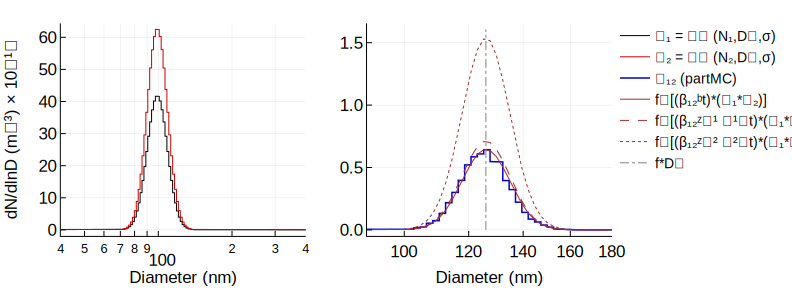

In [7]:
figure("Nimbus Sans L", 2, 5.5, 2, 8)
pre = 1e-10
p1 = plot(𝕟₁.Dp, pre*𝕟₁.S, xlim = (40, 400), color = :black, label = "𝕟₁ = 𝓛𝓝 (N₁,Dₘ,σ)", 
    xlabel = "Diameter (nm)", ylabel = "dN/dlnD (m⁻³) × 10⁻¹⁰",  t = :steppre, 
    xticks = [60,80,100,120,140,160])

p1 = plot!(𝕟₂.Dp, pre*𝕟₂.S, color = RGBA(0.8,0,0,1), label = "𝕟₂ = 𝓛𝓝 (N₂,Dₘ,σ)", t = :steppre)

p2 = plot(𝕟₁₂.Dp, pre*𝕟₁₂.S, color = RGBA(0.0,0.0,0.8), xlim = (90, 180), label = "𝕟₁₂ (partMC)", 
    xlabel = "Diameter (nm)", t = :steppre, lw = 1.5, xticks = [60,80,100,120,140, 160])
p2 = plot!(𝕟ₚᵇ.Dp,pre*𝕟ₚᵇ.S, color = :brown, label = "f⋅[(β₁₂ᵇt)*(𝕟₁*𝕟₂)]", lw = 1)
p2 = plot!(𝕟ₚᶻ¹.Dp,pre*𝕟ₚᶻ¹.S, color = :brown, label = "f⋅[(β₁₂ᶻ⁽¹ ⁻¹⁾t)*(𝕟₁*𝕟₂)]", lw = 1, ls = :dash)
p2 = plot!(𝕟ₚᶻ².Dp,pre*𝕟ₚᶻ².S, color = :brown, label = "f⋅[(β₁₂ᶻ⁽² ⁻²⁾t)*(𝕟₁*𝕟₂)]", lw = 1, ls = :dot)
p2 = plot!([f*Dm, f*Dm], [0,1.05*maximum(pre*𝕟ₚᶻ².S)], color = :grey, ls = :dashdot, label = "f*Dₘ") 

plot(p1,p2, layout = grid(1,2), left_margin = 35px, xaxis = :log10, fmt = :svg)

<b> Figure 3. </b> Comparison of assumed PartMC inferred size distribution and size distribution obtained from 𝕟ₚᵇ = f$⋅$((β₁₂$*$t)$*$(𝕟₁$.*$𝕟₂)). Left: Input size distributions to PartMC. Right: Blue histogram shows output size distribution from PartMC. The dark-red solid line corresponds to the analytical prediction. Note that the diameter is shifted by f$*$Dm due to the larger sphere equivalent volume of the dimers. Enhancement of concentration due to +1/-1 charge on the input size distribution is negligible and approximately a factor of two for +2/-2 charges. 

The DMA particle size distribution is not lognormal. To test of the analytical approximation holds, the model as also initialized with DMA type size distributions.

In [8]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/3                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
n = 6                                            # Upper number of charges
Λ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,n,:cylindrical)   # Specify DMA with negative polarity
bins,z₁,z₂ = 512, dtoz(Λ,500e-9),dtoz(Λ,20e-9)   # bins, upper, lower mobility limit
δ = setupDMA(Λ, z₁, z₂, bins);                   # Compute matrices

The API for Triangular size distributions is
```julia
ics = InitialConditionTriangular(N1, N2, Dm, Λ, δ)
```
where N1, N2, Dm are as above, and Λ, δ define the DMA. The width of the distribution is set by β.

In [9]:
cd("PartMC")         # Descend into directory PartMC
Random.seed!(30)     # Pick a random seed 
ics = InitialConditionTriangular(1e11, 1.5e11, 100.0, Λ, δ)    # Set initial conditions
x = runSimulation(ics,1,"triangular"; verbose = true, repeat = 1)  # Run simulations
cd("..")      # Come back 

repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1     0s  999372       0       0        0         0       0     0s     0s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1    10s  998722    2984       0        0         0       0    19s    97s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1    20s  998050    2965       0        0         0       0    20s    40s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1    30s  997444    2951       0        0         0       0    21s    21s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1    40s  996810    2938       0        0         0       0    21s    11s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil_out   n_nuc t_wall  t_rem
     1    50s  996200    2908       0        0         0       0    22s     4s
repeat  t_sim  n_part  n_coag  n_emit n_dil_in n_dil

In [10]:
r = 1                    # repeat number
Dm  = ics.Dm             # recover Dm from initial condition
N₁  = ics.Nt1            # recover N₁ from initial condition
N₂  = ics.Nt2            # recover N₂ from initial condition
t   = x[r].r[end,end].t  # end time of simulation. 
𝕟₁  = (𝕟0 + x[r].s1)            # reconstructed size distribution for 𝕟₁ from model output 
𝕟₂  = (𝕟0 + x[r].s2)            # reconstructed size distribution for 𝕟₂ from model output 
𝕟₁₂ = (𝕟0 + x[r].r[end,1].sc12) # reconstructed dimer size distribution 𝕟₁₂ from model output 

DataFrame(Input = [N₁,N₂], PartMC = [@sprintf("%.1E", sum(𝕟₁.N)), @sprintf("%.1E", sum(𝕟₂.N))])

,Input,PartMC
,Float64,String
1,1.0e11,1.0E+11
2,1.5e11,1.5E+11


<b> Table 3. </b> Comparison of assumed input number concentration and reconstructed output number concentration from PartMC simulation.

In [11]:
β₁₂ = β12(Dm*1e-9, Dm*1e-9, 0,0)         # Zebel-Brownian coagulation rate for no charge
β₁₂ᶻ⁽¹⁻¹⁾ = β12(Dm*1e-9, Dm*1e-9, 1,-1)  # +1 -1 charge
β₁₂ᶻ⁽²⁻²⁾ = β12(Dm*1e-9, Dm*1e-9, 2,-2)  # +1 -1 charge
f   = (Dm^3.0+Dm^3.0)^(1.0/3.0)/Dm 	     # diameter shift for larger particles

𝕟ₚᵇ = f⋅((β₁₂*t)*(𝕟₁*𝕟₂))              # Semi-analytical estimate using Browninan Kernel
𝕟ₚᶻ¹ = f⋅((β₁₂ᶻ⁽¹⁻¹⁾*t)*(𝕟₁*𝕟₂))       # Estimated enhancement for +1/-1 charged case
𝕟ₚᶻ² = f⋅((β₁₂ᶻ⁽²⁻²⁾*t)*(𝕟₁*𝕟₂))       # Estimated enhancement for +2/-2 charged caseprintln()

DataFrame(PartMC = [@sprintf("%.3E",sum(𝕟₁₂.N))], Analytical = [@sprintf("%.3E",sum(𝕟ₚᵇ.N))])

,PartMC,Analytical
,String,String
1,1.046E+09,1.097E+09


<b> Table 4. </b> Comparison of assumed PartMC inferred number concentration and number concentration obtained from f$⋅$((β₁₂$*$t)$*$(𝕟₁$.*$𝕟₂)).

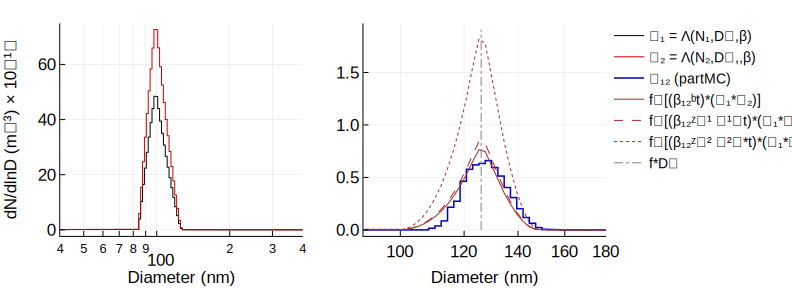

In [12]:
pre = 1e-10
p1 = plot(𝕟₁.Dp, pre*𝕟₁.S, xlim = (40, 400), color = :black, label = "𝕟₁ = Λ(N₁,Dₘ,β)", 
    xlabel = "Diameter (nm)", ylabel = "dN/dlnD (m⁻³) × 10⁻¹⁰",  t = :steppre, 
    xticks = [60,80,100,120,140,160])

p1 = plot!(𝕟₂.Dp, pre*𝕟₂.S, color = RGBA(0.8,0.0,0.0,1.0), label = "𝕟₂ = Λ(N₂,Dₘ,,β)", t = :steppre)

p2 = plot(𝕟₁₂.Dp, pre*𝕟₁₂.S, color = RGBA(0.0,0.0,0.8), xlim = (90, 180), label = "𝕟₁₂ (partMC)", 
    xlabel = "Diameter (nm)", t = :steppre, lw = 1.5, xticks = [60,80,100,120,140, 160])
p2 = plot!(𝕟ₚᵇ.Dp,pre*𝕟ₚᵇ.S, color = :brown, label = "f⋅[(β₁₂ᵇt)*(𝕟₁*𝕟₂)]", lw = 1)
p2 = plot!(𝕟ₚᶻ¹.Dp,pre*𝕟ₚᶻ¹.S, color = :brown, label = "f⋅[(β₁₂ᶻ⁽¹ ⁻¹⁾t)*(𝕟₁*𝕟₂)]", lw = 1, ls = :dash)
p2 = plot!(𝕟ₚᶻ².Dp,pre*𝕟ₚᶻ².S, color = :brown, label = "f⋅[(β₁₂ᶻ⁽² ⁻²⁾*t)*(𝕟₁*𝕟₂)]", lw = 1, ls = :dot)
p2 = plot!([f*Dm, f*Dm], [0,1.05*maximum(pre*𝕟ₚᶻ².S)], color = :grey, ls = :dashdot, 
    label = "f*Dₘ") 

plot(p1,p2, layout = grid(1,2), left_margin = 35px, xaxis = :log10, fmt = :svg)

<b> Figure 4. </b> Comparison of assumed PartMC inferred size distribution and size distribution obtained from 𝕟ₚᵇ = f$⋅$((k₁₂$*$t)$*$(𝕟₁$.*$𝕟₂)). Left: Input size distributions to PartMC. Right: Blue histogram shows output size distribution from PartMC. The dark-red solid line corresponds to the analytical prediction. Note that the diameter is shifted by f$*$Dm due to the larger sphere equivalent volume of the dimers. Enhancement of concentration due to +1/-1 charge on the input size distribution is negligible and approximately a factor of two for +2/-2 charges. Fpr the triangular case, the number concentration is predicted well (Table 4). However, the shape of the analytical prediction of the size distribution does not fit exactly the modeled shape. 

### Generalization 
The predicted number of dimers by the analytical approximation is 
<center> $N = β_{1,2}^B N_1N_2t$ </center> <br> 
How accurate is this estimate relative to the PartMC prediction? The average coagulation coefficient is enhanced for polydisperse coagulation because coagulation is more efficient for particles of dissimilar size (e.g. Table 12.4, Hinds 1999). To test how this might affect the dimer formation rate, a Monte-Carlo simulation is used. PartMC is is run for a range of sizes and geometric standard deviations. Number concentration for N1 and N2 are picked randomly within an interval where coagulated number concentration after time t remains small relative to the total particle number. This assumption mimicks the physics in the coagulation system described in Notebook 9a. After the simulation is completed the effective coagulation rate concentration is computed from the dimer size distribution  

```julia
β12eff = sum(𝕟₁₂)/(N₁*N₂*t) 
```
where sum(𝕟₁₂) is the number concentration of the dimers formed, N₁ and N₂ are the initial concentrations, and t is the total simulation time. This effectively observed coagulation rate is compared to the underlying Brownian coagulation rate computed from Eq. (15.33). The calculations are performed for lognormal distributions and triangular distributions.

### Step 1. Monte-Carlo Simulations

In [13]:
Random.seed!(10)
Narr = exp10.(range(10, stop=12, length=100))
Dgs = collect([20:20:100;200:200:1000])
σs = collect(1.05:0.05:1.3)

ics = InitialConditionLogNormal[]
for Dg in Dgs
    for σ in σs
        N = Narr[randperm(100)]
        push!(ics, InitialConditionLogNormal(N[1], N[2], Dg, σ))
    end
end

cd("PartMC")  # Descend into directory PartMC
l = Simulation[]
@showprogress 1 "Simulate..." for i = 1:length(ics)
    x = runSimulation(ics[i],1,"logn"; verbose = false, repeat=2)
    push!(l,x[1])
end
cd("..")      # Come back 

Simulate...100%|████████████████████████████████████████| Time: 0:57:56


### Step 2. Collate the Results
The code below extracts the effective $\beta$12 from the five repeats and multiple 5 time steps (10..60s) in the model and computes an average $\beta$12eff from these points for each simulation. 

In [14]:
β12eff = Array{Float64}(undef,length(Dgs)+1, length(σs)+1)
Dm = Array{Float64}(undef,length(Dgs)+1, length(σs)+1)
σk = Array{Float64}(undef,length(Dgs)+1, length(σs)+1)
mDm, mσ = Float64[], Float64[]
for i = 1:length(l)
    push!(mDm, l[i].case.Dm)
    push!(mσ, l[i].case.σ)
end
β12eff[2:end,1] = map(x -> x, mDm[1:length(σs):end])
β12eff[1,2:end] = map(x -> x, mσ[1:length(σs)])
β12eff[1,1] = NaN

# Compute the Browninan Kernel
f = collect([10e-9:20e-9:100e-9; 200e-9:200e-9:1000e-9])
g = map(x->β12brown(x, x), f)

for i = 1:length(σs)
    β12eff[2:end,i+1] = map(x -> mean(x.k12), l[i:length(σs):end]) # average the different runs
    β12eff[2:end,i+1] = β12eff[2:end,i+1]./g                       # Compute the ratio
end
table = DataFrame(round.(β12eff,digits=2))
rename!(table,f => t for (f, t) = zip([:x1, :x2, :x3, :x4, :x5, :x6, :x7],[:Dₘ, :σ₁, :σ₂, :σ₃, :σ₄, :σ₅, :σ₆]))

,Dₘ,σ₁,σ₂,σ₃,σ₄,σ₅,σ₆
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,NaN,1.05,1.1,1.15,1.2,1.25,1.3
2,20.0,1.21,1.2,1.21,1.24,1.16,1.25
3,40.0,0.85,0.93,0.94,0.96,1.02,1.01
4,60.0,0.91,0.84,0.94,0.91,1.01,0.91
5,80.0,0.92,0.91,0.88,0.95,0.96,0.94
6,100.0,0.91,0.92,0.94,0.96,0.98,1.04
7,200.0,0.99,0.97,1.04,1.01,1.04,1.03
8,400.0,1.01,1.01,1.01,1.0,1.03,1.06
9,600.0,0.95,0.97,1.0,1.01,1.03,1.04


<b> Table 5. </b> Column Dₘ: Mode diameter for simulation. Row 1: List of geometric standard deviation for simulation. All other entries, ratio of effective $\beta_{1,2}$ derived as average from five PartMC repeat runs and Brownian coagulation kernel computed via Eq. (15.33) in Jacobson (2005), the same kernel that is used in PartMC. The table shows that the analytical approximation of number concentrion fir distributions with σg < 1.3 and sizes 10 < D < 1000 nm is within a few % of the model simulation.

In [15]:
Random.seed!(10)
Narr = exp10.(range(10, stop=12, length=100))

t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/3                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 6                                            # Upper number of charges
Λ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,:cylindrical)   # Specify DMA with negative polarity
bins,z₁,z₂ = 512, dtoz(Λ,900e-9),dtoz(Λ,10e-9)   # bins, upper, lower mobility limit
δ = setupDMA(Λ, z₁, z₂, bins);                   # Compute matrices

Dgs = collect([40:20:100;200:200:600])           # Stay within grid for simulations

Λs,δs = DMAconfig[], DifferentialMobilityAnalyzer[]
β = [1.0/10.0, 1.0/5.0, 1.0/3.0]                 # Three sheath-to-sample flow ratios
for i = 1:length(β)
    push!(Λs, DMAconfig(t,p,qsa,qsa/β[i],r₁,r₂,l,leff,:-,n,:cylindrical))
    push!(δs, setupDMA(Λs[i], z₁, z₂, bins))          
end

# Setup simulation initial conditions as a list
ics = InitialConditionTriangular[]
for Dg in Dgs
    for i in 1:length(Λs)
        N = Narr[randperm(100)]
        push!(ics, InitialConditionTriangular(N[1], N[2], Dg, Λs[i], δs[i]))
    end
end

# Run simulations
cd("PartMC")  # Descend into directory PartMC
l = Simulation[]
@showprogress 1 "Simulate..." for i = 1:length(ics)
    x = runSimulation(ics[i],1,"triangular"; verbose = false)
    push!(l,x[1])
end
cd("..")

Simulate...100%|████████████████████████████████████████| Time: 0:10:48


In [16]:
β12eff = Array{Float64}(undef,length(Dgs)+1, length(β)+1)
Dm = Array{Float64}(undef,length(Dgs)+1, length(β)+1)
mDm = Float64[]
for i = 1:length(l)
    push!(mDm, l[i].case.Dm)
end

β12eff[2:end,1] = map(x -> x, mDm[1:length(β):end])
β12eff[1,2:end] = map(x -> x, β[1:length(β)])
β12eff[1,1] = NaN

# Compute the Browninan Kernel
f = collect([40:20:100; 200:200:600])
g = map(x->β12brown(x*1e-9, x*1e-9), f)

for i = 1:length(β)
    β12eff[2:end,i+1] = (map(x -> mean(x.k12), l[i:length(β):end]))   # Average rate
    β12eff[2:end,i+1] = β12eff[2:end,i+1]./g                          # Compute the ratio
end

table = DataFrame(round.(β12eff,digits=2))
rename!(table, f => t for (f, t) = zip([:x1, :x2, :x3, :x4], [:Dₘ, :β₁, :β₂, :β₃]))

,Dₘ,β₁,β₂,β₃
,Float64,Float64,Float64,Float64
1,NaN,0.1,0.2,0.33
2,40.0,0.96,0.97,0.96
3,60.0,0.97,0.91,0.96
4,80.0,0.93,0.98,0.99
5,100.0,0.98,1.01,1.01
6,200.0,0.99,0.94,0.99
7,400.0,0.97,0.93,0.97
8,600.0,1.03,0.99,0.91


<b> Table 6. </b> Column Dₘ: Mode diameter for simulation. Row 1: List of sample-to-sheath flow ratios. All other entries, ratio of effective $\beta_{1,2}$ derived as average from five PartMC repeat runs and Brownian coagulation kernel computed via Eq. (15.33) in Jacobson (2005), the same kernel that is used in PartMC. The table shows that the analytical approximation of number concentrion fir distributions with sheath-to-sample flow ratio < 1/10 and sizes 40 < D < 600 nm is within a few % of the model simulation.

### References

Jacobson, M. Z. (2005) Fundamentals of Atmospheric Modeling. Second Edition, Cambridge University Press. 

Hinds, W. C. (1999) Aerosol Technology, Properties, Behavior, and Measurement of Airborne Particles, Second Edition, John Wiley & Sons, Inc.

Riemer, N.,  M. West, R. A. Zaveri, and R. C. Easter (2009) Simulating the evolution of soot mixing state with a particle-resolved aerosol model, Journal of Geophysical Research 114(D09202), DOI:10.1029/2008JD011073. 

Tian, J., B. T. Brem, M. West, T. C. Bond, M. J. Rood & N. Riemer (2017) Simulating aerosol chamber experiments with the particle-resolved aerosol model PartMC, Aerosol Science and Technology, 51:7, 856-867, DOI:10.1080/02786826.2017.1311988

Zebel, G. (1957) Zur Theorie des Verhaltens elektrisch geladener Aerosole, Kolloid-Zeitschrift, (1), 37–50, DOI:10.1007/BF01734032.